<a href="https://colab.research.google.com/github/phantom-balance/HybridEnergy/blob/master/Copy_of_Solar_Battery_gasifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEW

In [ ]:
# pymoo used for optimization
from IPython.display import clear_output
!pip install pymoo
clear_output()

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymoo
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

In [ ]:
# reading the hourly energy csv file "contains hourly data for deficits, solar radiation and ambient air temperature(Jumla)"
df = pd.read_csv('HOURLY_DATA_new.csv')
df = df[0:24*365*20]
'''
     csv file has deficit energy in MWh, solar radiation(ghi) in W/m2, air temperature in celcius.
    We perform the analysis in terms of KW.
'''
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

In [ ]:
len(df)

175200

In [ ]:
df.describe()

,Unnamed: 0,ghi,air_temperature,deficit_energy
count,175200.000000,175200.000000,175200.000000,1.752000e+05
mean,87599.500000,0.218271,11.596737,2.231777e+05
std,50576.027918,0.311458,8.223488,4.916429e+05
min,0.000000,0.000000,-8.630000,-1.302164e+06
25%,43799.750000,0.000000,4.888750,-1.347972e+05
50%,87599.500000,0.005384,12.802500,1.807045e+05
75%,131399.250000,0.403645,17.676667,5.130801e+05
max,175199.000000,1.147850,29.931667,2.084551e+06


In [ ]:
df['deficit_energy'].sum()

39100728439.68564

In [ ]:
'''
    All the necessary constants required for modeling.
'''
N = 20 # project_life
i = 0.06 # interest_rate

#chabom
solar_cost_unit = 727 # usd/kW(capex)
solar_OM = 4 # usd/kW.year(opex)

CRF = (i*((1+i)**N))/(((1+i)**N)-1) # capital recovery factor
d_f = 0.88 #derating_factor
Gt_stc = 1 #kw/m2
ap = -0.0035 #solar mod temp coeff of power(%/oC)
T_cstc = 25 #oC standard temp
NOCT = 45 #oC
n_bat = 0.92 #round trip efficieny

gasifier_cost_unit = 2300 # usd/kW(capex)
gasifier_OM = 2 # usd/kW.year(opex)
gasifier_CUF = 0.55 # capacity utilization factor

battery_cost_unit = 145 # usd/kW(capex)
battery_OM_per = 1.5 # 1.5% of capex annuity(opex)

inv_cost_unit = 300 # usd/kW(capex)
inv_OM = 1 # usd/kW.year(opex)
inv_cap = np.array(solar_ene_array).max()

In [ ]:
'''
    Calculating the Annualized system cost(ASC) and the levelised cost of energy(LCOE)
'''
def cost_inv(inv):
  inv_cost = inv*((CRF*inv_cost_unit)+inv_OM)
  return inv_cost

def cost_pv(solar):
  solar_cost = solar*((CRF*solar_cost_unit)+solar_OM)
  return solar_cost

def cost_gasifier(gasifier):
  gasifier_cost = gasifier*((CRF*gasifier_cost_unit)+gasifier_OM)
  return gasifier_cost

def cost_battery(battery):
  battery_cap = battery*battery_cost_unit
  battery_op = battery_cap*CRF*battery_OM_per/100
  battery_cost = battery_cap*CRF+battery_op
  return battery_cost

def LCOE(total_energy_prod, solar, gasifier, battery):
  ASC = cost_pv(solar)+cost_gasifier(gasifier)+cost_battery(battery)#+cost_inv(inv_cap)
  energy_prod_per_year = total_energy_prod/N
  lcoe = ASC/(energy_prod_per_year)
  return ASC, lcoe

In [ ]:
'''
    Calculating the energy produced by the solar panel and gasifier.
'''
def solar_ene_prod(solar_rate, solar_rad, temp):
  T_cell = temp+Gt_stc*((NOCT-20)/0.8)
  p_op = solar_rate*d_f*(solar_rad/Gt_stc)*(1+ap*(T_cell-T_cstc))
  return p_op

def gasifier_ene_prod(gasifier_rate):
  return gasifier_rate*gasifier_CUF

In [ ]:
'''
    Hybrid Energy system operational strategy
'''
def Energy_prod_(energy_def, battery_E, battery_max, solar_rate, solar_rad, gasifier_rate, temp):
  energy_def=-energy_def
  energy_prod = 0
  energy_served = 0
  solar_energy = 0
  gasifier_energy = 0
  battery_E_up = battery_E
  battery_supply = 0
  solar_energy = solar_ene_prod(solar_rate, solar_rad, temp)

  if energy_def>0:
    '''
    Energy deficit strategy
    '''
    if solar_energy-energy_def<0:
      '''
      Solar cannot fulfill the energy deficit.
      Run battery and gasifier.
      '''
      # req_energy needs to be addressed by gasifier and battery
      req_energy = energy_def-solar_energy
      energy_served+=solar_energy

      if battery_E>battery_max*0.3:
        if req_energy<=(battery_E-battery_max*0.3):
          '''
          req_energy met by only battery
          '''
          battery_supply = req_energy
          battery_E_up = battery_E-req_energy
          energy_served+=battery_supply

        else:
          '''
          req_energy met by battery and gasifier
          '''
          gasifier_E_req = req_energy-(battery_E-battery_max*0.3)
          battery_supply = battery_E-0.3*battery_max
          energy_served+=battery_supply
          battery_E_up = 0.3*battery_max
          gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

          if gasifier_energy_op>gasifier_E_req:
            gasifier_energy = gasifier_E_req
            energy_served+=gasifier_energy

          else:
            pass
            '''
            Hybrid energy system cannot fulfill the energy deficit.
            New hybrid combination required.
            '''
            # print("# THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

      else:
        '''
        req_energy met only by gasifier
        '''
        gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

        if req_energy<gasifier_energy_op:
          gasifier_energy = req_energy
          energy_served+=gasifier_energy
        else:
          pass
          '''
          Hybrid energy system cannot fulfill the energy deficit.
          New hybrid combination required.
          '''
          # print("THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

    else:
      '''
      Solar can fulfill the energy deficit.
      Extra energy from the solar panel is used to charge the battery.
      '''
      energy_served+=energy_def # solar panel served the entire deficit energy
      Pch_t = solar_energy-energy_def # extra energy from solar used for charging battery
      Ech_t = Pch_t*n_bat

      if Ech_t<=battery_max-battery_E:
        #battery isn't fully charged
        battery_E_up = battery_E+Ech_t

      else:
        #battery gets fully charged, E_dump is the remaining energy served to the grid
        battery_E_up = battery_max
        E_dump = Ech_t - (battery_max-battery_E)
        energy_served+=(E_dump/n_bat)
        Ech_t = battery_max-battery_E

    energy_prod = solar_energy + gasifier_energy

  else :
    '''
    Energy surplus strategy
    '''
    energy_prod=solar_energy+gasifier_energy
    surplus_ene = abs(energy_def)

    Pch_t = solar_energy
    Ech_t = Pch_t*n_bat

    if Ech_t<=battery_max-battery_E:
      battery_E_up = battery_E+Ech_t

    else:
      battery_E_up = battery_max
      E_dump = Ech_t - (battery_max-battery_E)
      energy_served+=(E_dump/n_bat)
      Ech_t = battery_max-battery_E

  return energy_served, battery_supply, battery_E_up, solar_energy, gasifier_energy

In [ ]:
'''
    Optimization for minimizing the LCOE.
'''
class ProblemWrapper(Problem):
  def _evaluate(self, designs, out, *args, **kwargs):
    res = []
    res1 =[]
    for design in designs:

      solar, gasifier, battery = design

      count = 0
      Energy_prod_N = 0 #total energy throughout the project life produced
      battery_E = battery

      for i in range(len(df)):
        n_battery_E = battery_E
        Energy_served,battery_supply, battery_E, _, _ = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
        Energy_prod_N += Energy_served
        energy_tot = df['deficit_energy'][i]+Energy_served
        energy_tot = round(energy_tot, 4)

        if energy_tot<0 and count!=1:
          count = 1
          break

      asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
      res.append(lcoe)
      res1.append(count)
    out['F']=np.array(res)
    out['H']=np.array(res1)

problem = ProblemWrapper(n_var=3, n_obj=1, n_eq_constr=1, xl=[0, 0, 0], xu=[7440937, 2360000, 7440937],vtype=int)

In [ ]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
algorithm = GA(pop_size=20,
               sampling=IntegerRandomSampling(),
               crossover=SBX(prob=0.95, eta=3.0, vtype=int, repair=RoundingRepair()),
               mutation=PM(prob=0.1, eta=3.0, vtype=int, repair=RoundingRepair()),
               eliminate_duplicate=True)
stop_criteria = ('n_gen', 50)

In [ ]:
%%time
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   verbose=True,
                   seed=42,
                   save_history=True)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       20 |  0.000000E+00 |  0.9499050000 |  0.0960233381 |  0.0960233381
     2 |       40 |  0.000000E+00 |  0.8999100000 |  0.0928820218 |  0.0897407055
     3 |       60 |  0.000000E+00 |  0.6999300000 |  0.0979544138 |  0.0897407055
     4 |       80 |  0.000000E+00 |  0.3999600000 |  0.1004070864 |  0.0897407055


In [ ]:
'save the optimization results in the file'
import pickle
with open('pv-gas-bat_ga-res.pkl', 'wb') as file:
    pickle.dump(results, file)

# POST OPTIMIZATION

In [ ]:
with open('pv-gas-bat_ga-res.pkl', 'rb') as file:
    results = pickle.load(file)

In [ ]:
'''
Optimized results for SOO.
'''
solar, gasifier, battery = results.X
print(f"Solar:{solar}KW, Gasifier: {gasifier}KW, Battery: {battery}KWh || LCOE: {results.F}USD/KWh")

Solar:7440824KW, Gasifier: 1877718KW, Battery: 5569543KWh || LCOE: [24.8233434]USD/KWh


In [ ]:
# asc pie chart
solar_asc = cost_pv(solar)
gasifier_asc = cost_gasifier(gasifier)
battery_asc = cost_battery(battery)
inv_asc = cost_inv(inv_cap)

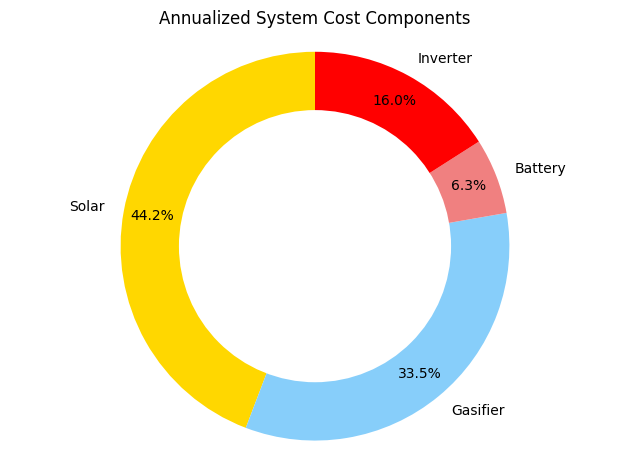

In [ ]:
# prompt: make a pie chart with hole in the midlle for showing the component cost from above data

# Data for the pie chart
labels = ['Solar', 'Gasifier', 'Battery', 'Inverter']
sizes = [solar_asc, gasifier_asc, battery_asc, inv_asc]
colors = ['gold', 'lightskyblue', 'lightcoral', 'red']

# Create the pie chart with a hole in the middle
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a circle in the middle to create the donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.title('Annualized System Cost Components')
plt.tight_layout()
plt.show()

In [ ]:
'''
Viewing the operation of the optimized hybrid energy system.
'''
# solar, gasifier, battery = results.X
solar, gasifier, battery = 7440824, 1877718, 5569543

# Solar:3717620.230751795KW, Gasifier: 2209925.350228307KW, Battery: 4446649.505009017KWh || LCOE: [0.12784646]USD/KWh

solar_array = []
gasifier_array = []
battery_array = []
battery_supply_array = []
deficit_array = []

total_supply = []

count = 0
gasifier_up_hr = 0
gasifier_energy_tot = 0
battery_energy_tot = 0
solar_energy_tot = 0
Energy_prod_N = 0
battery_E = battery
solar_ene_array = []
for i in range(len(df)):
# for i in range(8760):

  # Energy_produced = Energy_prod(solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_served, battery_supply, battery_E, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_served
  gasifier_energy_tot+=gasifier_ene
  battery_energy_tot+=battery_supply
  solar_ene_served = Energy_served-gasifier_ene-battery_supply
  solar_energy_tot+=solar_ene_served
  solar_ene_array.append(solar_ene)


  if round(gasifier_ene, 2)>0:
    # print(gasifier_ene)
    # print(i)


    gasifier_up_hr+=1

  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  battery_supply_array.append(battery_supply)
  battery_array.append(battery_E)
  total_supply.append(battery_supply+gasifier_ene+solar_ene)
print(gasifier_up_hr)
print(gasifier_energy_tot)
asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
print(asc, lcoe)

5411
1741340650.7232442
1134158711.6337667 0.09844606358512539


In [ ]:
df

,Unnamed: 0,time,ghi,air_temperature,deficit_energy
0,0,2024-01-01 00:00:00,0.0,-1.171667,-1.574314e+05
1,1,2024-01-01 01:00:00,0.0,-2.305000,-1.560858e+05
2,2,2024-01-01 02:00:00,0.0,-2.963333,-1.554130e+05
3,3,2024-01-01 03:00:00,0.0,-3.281667,-1.560858e+05
4,4,2024-01-01 04:00:00,0.0,-3.698333,-1.655048e+05
...,...,...,...,...,...
175195,175195,2043-12-31 19:00:00,0.0,-0.078333,1.309289e+06
175196,175196,2043-12-31 20:00:00,0.0,-1.063333,1.040090e+06
175197,175197,2043-12-31 21:00:00,0.0,-1.611667,4.328608e+05
175198,175198,2043-12-31 22:00:00,0.0,-2.110000,3.930927e+05


In [ ]:
np.array(solar_ene_array).max()

6666216.465636096

(array([9.154e+04, 3.420e+03, 2.200e+03, 2.160e+03, 1.760e+03, 1.620e+03,
        1.420e+03, 1.360e+03, 1.360e+03, 1.640e+03, 1.760e+03, 1.380e+03,
        1.040e+03, 1.360e+03, 1.200e+03, 1.380e+03, 1.360e+03, 1.280e+03,
        1.120e+03, 1.000e+03, 1.240e+03, 1.300e+03, 1.220e+03, 1.240e+03,
        1.120e+03, 1.480e+03, 9.400e+02, 1.300e+03, 1.320e+03, 1.240e+03,
        1.300e+03, 1.160e+03, 1.240e+03, 1.180e+03, 1.080e+03, 1.200e+03,
        1.060e+03, 1.260e+03, 8.000e+02, 8.200e+02, 8.000e+02, 1.020e+03,
        9.800e+02, 1.080e+03, 1.240e+03, 1.020e+03, 1.200e+03, 1.240e+03,
        1.260e+03, 1.140e+03, 1.100e+03, 1.160e+03, 9.600e+02, 9.800e+02,
        9.400e+02, 6.800e+02, 7.400e+02, 7.200e+02, 8.200e+02, 9.200e+02,
        7.600e+02, 8.200e+02, 6.800e+02, 8.000e+02, 7.800e+02, 7.400e+02,
        8.600e+02, 8.000e+02, 1.060e+03, 7.600e+02, 7.000e+02, 6.800e+02,
        3.800e+02, 2.000e+02, 1.400e+02, 1.000e+02, 8.000e+01]),
 array([      0.        ,   86574.23981346,  17

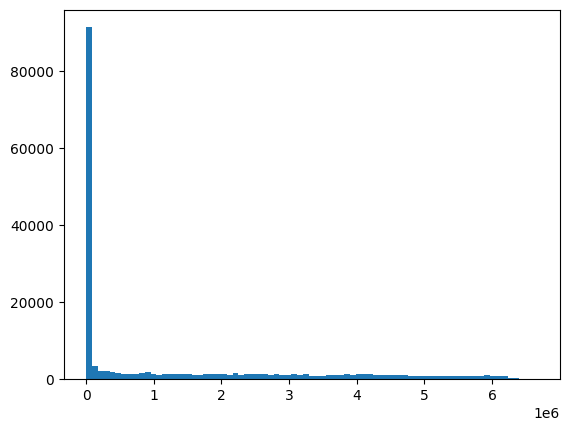

In [ ]:
plt.hist(np.array(solar_ene_array), bins='auto')

In [ ]:
solaraaray=np.trim_zeros(np.array(solar_ene_array))

(array([9.154e+04, 3.420e+03, 2.200e+03, 2.160e+03, 1.760e+03, 1.620e+03,
        1.420e+03, 1.360e+03, 1.360e+03, 1.640e+03, 1.760e+03, 1.380e+03,
        1.040e+03, 1.360e+03, 1.200e+03, 1.380e+03, 1.360e+03, 1.280e+03,
        1.120e+03, 1.000e+03, 1.240e+03, 1.300e+03, 1.220e+03, 1.240e+03,
        1.120e+03, 1.480e+03, 9.400e+02, 1.300e+03, 1.320e+03, 1.240e+03,
        1.300e+03, 1.160e+03, 1.240e+03, 1.180e+03, 1.080e+03, 1.200e+03,
        1.060e+03, 1.260e+03, 8.000e+02, 8.200e+02, 8.000e+02, 1.020e+03,
        9.800e+02, 1.080e+03, 1.240e+03, 1.020e+03, 1.200e+03, 1.240e+03,
        1.260e+03, 1.140e+03, 1.100e+03, 1.160e+03, 9.600e+02, 9.800e+02,
        9.400e+02, 6.800e+02, 7.400e+02, 7.200e+02, 8.200e+02, 9.200e+02,
        7.600e+02, 8.200e+02, 6.800e+02, 8.000e+02, 7.800e+02, 7.400e+02,
        8.600e+02, 8.000e+02, 1.060e+03, 7.600e+02, 7.000e+02, 6.800e+02,
        3.800e+02, 2.000e+02, 1.400e+02, 1.000e+02, 8.000e+01]),
 array([      0.        ,   86574.23981346,  17

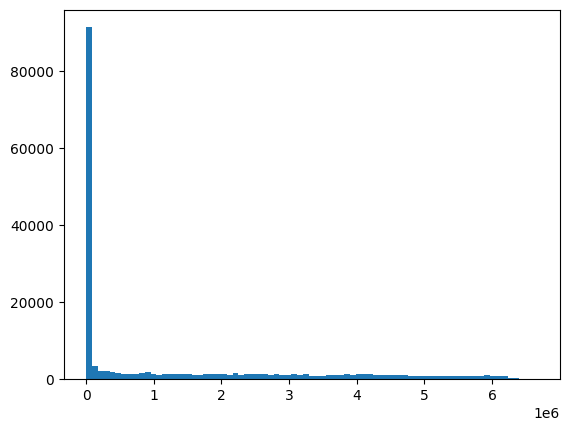

In [ ]:
plt.hist(np.array(solar_ene_array), bins='auto')

In [ ]:
solaraaray.mean()

1308968.2055905142

In [ ]:
# prompt: remove all the values that are less than 2000000 in the solaraaray

solaraaraymore = solaraaray[solaraaray >= 5000000]
solaraaraymore.sum()

69282490555.63223

In [ ]:
solaraarayless = solaraaray[solaraaray <= 5000000]
solaraarayless.sum()

160031722477.15323

In [ ]:
solaraarayless.sum()-solaraaraymore.sum()

90749231921.521

In [ ]:
deficit_array = df['deficit_energy'].to_numpy()
deficit_array

array([-157431.365538, -156085.798311, -155413.014698, ...,
        432860.831886,  393092.698922,  377797.263166])

In [ ]:
deficit_only_array = np.where(deficit_array>0, 0, deficit_array)
deficit_tot=-deficit_only_array.sum()
deficit_only_array

array([-157431.365538, -156085.798311, -155413.014698, ...,
             0.      ,       0.      ,       0.      ])

In [ ]:
solar_energy_tot = deficit_tot-gasifier_energy_tot-battery_energy_tot

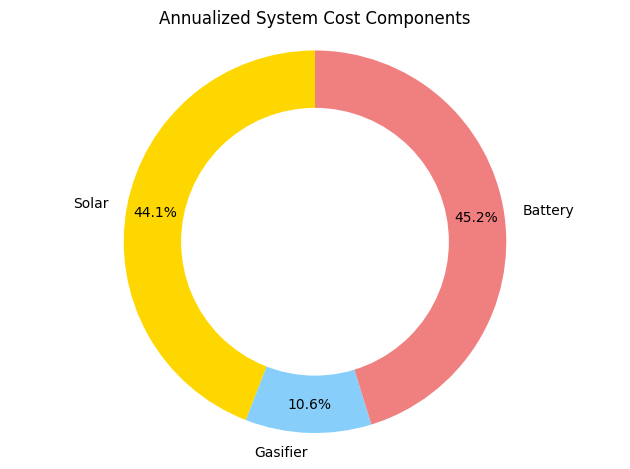

In [ ]:
# prompt: make a pie chart with hole in the midlle for showing the component cost from above data

# Data for the pie chart
labels = ['Solar', 'Gasifier', 'Battery']
sizes = [solar_energy_tot, gasifier_energy_tot, battery_energy_tot]
colors = ['gold', 'lightskyblue', 'lightcoral']

# Create the pie chart with a hole in the middle
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a circle in the middle to create the donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.title('Annualized System Cost Components')
plt.tight_layout()
plt.show()

#old


In [ ]:
'''
Optimized results for SOO.
'''
solar, gasifier, battery = results.X
print(f"Solar:{solar}KW, Gasifier: {gasifier}KW, Battery: {battery}KWh || LCOE: {results.F}USD/KWh")

Solar:7440824KW, Gasifier: 1877718KW, Battery: 5569543KWh || LCOE: [0.08200048]USD/KWh


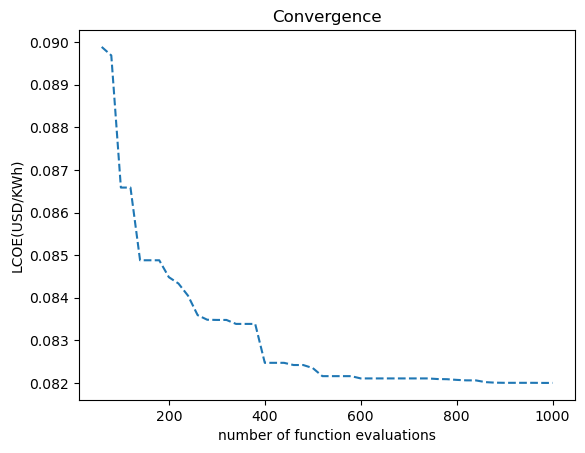

In [ ]:
'''
Convergence plot for SOO.
'''
import numpy as np
import matplotlib.pyplot as plt

n_evals = np.array([e.evaluator.n_eval for e in results.history])
opt = np.array([e.opt[0].F for e in results.history])

plt.title("Convergence")
plt.plot(n_evals[2:], opt[2:], "--")
plt.xlabel("number of function evaluations")
plt.ylabel("LCOE(USD/KWh)")
plt.show()

In [ ]:
len(df)

183960

In [ ]:
8760*21

183960

In [ ]:
'''
Viewing the operation of the optimized hybrid energy system.
'''
# solar, gasifier, battery = results.X
solar, gasifier, battery = 7440824, 1877718, 5569543

# Solar:3717620.230751795KW, Gasifier: 2209925.350228307KW, Battery: 4446649.505009017KWh || LCOE: [0.12784646]USD/KWh

solar_array = []
gasifier_array = []
battery_array = []
battery_supply_array = []
deficit_array = []

total_supply = []

count = 0
gasifier_up_hr = 0
gasifier_energy = 0
battery_tot_energy = 0
solar_tot_energy = 0
Energy_prod_N = 0
battery_E = battery
# for i in range(len(df)):
for i in range(8760):

  # Energy_produced = Energy_prod(solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_served, battery_supply, battery_E, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_served
  gasifier_energy+=gasifier_ene
  battery_tot_energy+=battery_supply



  if round(gasifier_ene, 2)>0:
    # print(gasifier_ene)
    # print(i)


    gasifier_up_hr+=1

  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  battery_supply_array.append(battery_supply)
  battery_array.append(battery_E)
  total_supply.append(battery_supply+gasifier_ene+solar_ene)
print(gasifier_up_hr)
print(gasifier_energy)
asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
print(asc, lcoe)

5411
1741340650.7232442
991696664.4884094 0.08608022130231466


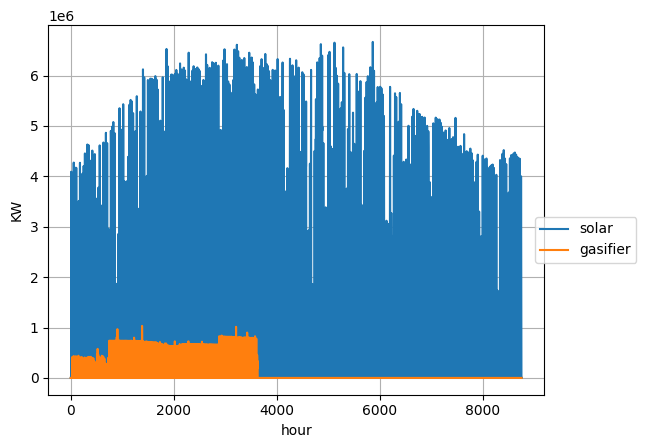

In [ ]:
'''
Viewing the operation of the optimized hybrid energy system.
'''
i = 0 # start hour
j = 8760 # end hour
x = np.arange(i,j)
plt.plot(x,solar_array[i:j], label='solar')
plt.plot(x,gasifier_array[i:j], label='gasifier')
# plt.plot(x,battery_array[i:j], label = 'battery-SOC')
# plt.plot(x,battery_supply_array[i:j], label = 'battery')
# plt.plot(x,-np.array(deficit_array[i:j]), label = 'deficit')
# plt.plot(x,-np.array(deficit_array[i:j]), label = 'deficit/surplus')
# plt.plot(x,np.array(deficit_array[i:j]), label = 'surplus')
plt.xlabel("hour")
plt.ylabel("KW")
# plt.plot(x,total_supply[i:j], label = 'total')
plt.grid()
plt.legend(loc='upper right',bbox_to_anchor=(1.2,0.5))